In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 414113133806188969
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1426918195
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8067861365658666228
physical_device_desc: "device: 0, name: GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [1]:
import pandas as pd
import os
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer


In [2]:
base_dir = 'd:\\MyProject\\Rumor_Detection'

In [3]:
os.listdir(base_dir)

['.idea',
 'pre_process.py',
 'run_model.py',
 'tweets_file.csv',
 'tweets_file_new.xlsx']

In [4]:
df = pd.read_excel('D:\\MyProject\\Rumor_Detection\\tweets_file_new.xlsx', encoding = 'utf-8')
df.columns = ['tweet', 'label']
df

,tweet,label
0,Charlie Hebdoâ€™s Last Tweet Before Shootings ...,0
1,Prediction: the #CharlieHebdo massacre will no...,0
2,10:28am Charlie Hebdo account mocks ISIS leade...,0
3,If your faith isn't strong enough to cope with...,0
4,Just arrived at scene of massacre #Paris #char...,0
...,...,...
101840,"â€œ@PoliceAU: Sadly, at this stage, there are ...",1
101841,"â€œ@PoliceAU: Sadly, at this stage, there are ...",1
101842,@PoliceAU no :'(,1
101843,@PoliceAU nonono,1


In [5]:

#Balanced Dataset

dfb_r = df[df['label'] == 1]     #rumors
dfb_nr = df[df['label'] == 0]    #Non-Rumors

dfb_nr = dfb_nr.sample(n=30965)  #sampling equal amount of Non-Rumors

dfb = dfb_r.append(dfb_nr)        #concatenating Rumors and Non-Rumors
dfb= dfb.sample(frac=1).reset_index(drop=True)   #Shuffling the dataset

In [6]:
dfb

,tweet,label
0,I see a lot of religious whiteness over here. ...,0
1,@democracynow no self-respecting police state ...,0
2,@Phil_N_C that's my point - you invaded anothe...,0
3,.@MIFheili1960 Bad for Islam: all these prison...,1
4,@jaggy123 @MsRock4Ever @AlwaysThinkHow @DanteB...,1
...,...,...
61925,@CBCAlerts The cowardly bastards.If you believ...,1
61926,.@mollycrabapple Police LOVE using the passive...,0
61927,@PzFeed â¬…ï¸ al nursa and ISIS âž¡ï¸\r\nAnd...,1
61928,@nytimes For Only $9 You Can Buy 3K Followers ...,1


In [7]:
def preprocess(text):
    
#     PreProcessing 
#     1. Lower
#     2. Removing Speciial Characters
#     3. Removing numbers
#     4. Removing Mentions
#     5. Removing Urls
#     6. Removing Stopwords
#     7. Removing all non-alphanumeric characters
#     8. Lemmatization
    
    
    lemmatizer = WordNetLemmatizer()
    text = text.lower()
    
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+", flags=re.UNICODE)
        
    text = emoji_pattern.sub(r'',text)                          #removes emojis and other symbols 
    text = re.sub('[,.?~!$%&*#/]','',text)                      #special Characters
    text = re.sub('[\d]','',text)                               #removes numbers
    words = [word for word in text.split() if '@' not in word]  #removes mentions
    words = [word for word in words if 'https:' not in word or 'http:' not in word]  #removes urls
    words = [word for word in words if word not in stopwords.words('english')]       #removes stopwords
    words = [word for word in words if  not re.search('\W+',word)]                   #removes non-alphanumerics chars
    words = [lemmatizer.lemmatize(word) for word in words ]                          #Lemmatization
    text = ' '.join(words)
    
    return text
    
text = "hello this i$ some# @sting /// â€˜banksyâ€™  \U0001F600   with some .,m.m *& daf8 random things in it."
print(preprocess(text))

hello mm daf random thing


In [10]:
## Unbalanced Dataset
#df_new['tweet'].apply(preprocess)

#Preprocessing Balanced Dataset
dfb['tweet'] = dfb['tweet'].apply(preprocess)

In [11]:
dfb.columns = ['tweet', 'label']
dfb

,tweet,label
0,hear hear paul,0
1,french charliehebdo twitter photo go viral par...,0
2,important,1
3,sydneysiege report incident sydney opera house,1
4,shocker ferguson police beat man charged bleeding,1
...,...,...
61925,speaking,1
61926,,1
61927,reliance traveller jihad mean war agnst,0
61928,try reading comprehension,1


In [12]:
from sklearn.model_selection import train_test_split

# x = df_new['tweet']
# y = df_new['label']

x = dfb['tweet']
y = dfb['label']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state = 42)

In [14]:
x_train

44088            know usans seen guy made speech priceless
53317        acting like wild animal cop trying intimidate
43724    look like missed last time already shot maybe ...
16758                             probably nonsense though
29772                        relevant r u stupid something
                               ...                        
54343    revoke terrorist passport sincerely valerie ja...
38158    several hostage freed tottenham club shop wow ...
860      see lot apoligists well islamism smth alien mu...
15795    waiting shoe drop b psychicdetective wakeupame...
56422                                   wow prayer soldier
Name: tweet, Length: 49544, dtype: object

In [15]:
import numpy as np
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



vocab_size = 1000
embedding_dim = 50
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000
GLOVE_DIR = "D:\\MyProject\\glove.twitter.27B"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)






#Unpacking Glove Embedding
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.50d.txt'), encoding = 'utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

#Creating Glove Embedding Matrix
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Found 1193514 word vectors.


In [13]:
#model 1: Embeddings
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable = False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') ])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


#model 2: Embeddings with Conv1D and maxpooling1D
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable = False),
#     tf.keras.layers.Conv1D(64,4,activation = 'relu'),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.MaxPooling1D(2),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid') ])
# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# model.summary()







num_epochs = 20
history = model.fit(training_padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test),batch_size = 1024, verbose=1)



NameError: name 'tf' is not defined

In [31]:
y_train_prediction = model.predict(training_padded)
y_test_prediction =    model.predict(testing_padded)
y_train_prediction[y_train_prediction >= 0.5] = 1
y_train_prediction[y_train_prediction <  0.5] = 0
y_test_prediction[y_test_prediction >= 0.5] = 1
y_test_prediction[y_test_prediction <  0.5] = 0

In [32]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn import metrics
import numpy as np

print("Accuracy (training data)\n", metrics.accuracy_score(y_train, y_train_prediction))
print("Accuracy (test data)\n", metrics.accuracy_score(y_test, y_test_prediction))

print("Confusion matrix (training data)\n", metrics.classification_report(y_train, y_train_prediction))
print("Confusion matrix (test data)\n", metrics.classification_report(y_test, y_test_prediction))


Accuracy (training data)
 0.6840384304860326
Accuracy (test data)
 0.6227999354109478
Confusion matrix (training data)
               precision    recall  f1-score   support

           0       0.67      0.74      0.70     24799
           1       0.70      0.63      0.67     24745

    accuracy                           0.68     49544
   macro avg       0.69      0.68      0.68     49544
weighted avg       0.69      0.68      0.68     49544

Confusion matrix (test data)
               precision    recall  f1-score   support

           0       0.61      0.67      0.64      6166
           1       0.64      0.57      0.60      6220

    accuracy                           0.62     12386
   macro avg       0.62      0.62      0.62     12386
weighted avg       0.62      0.62      0.62     12386



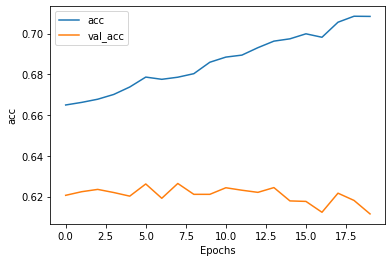

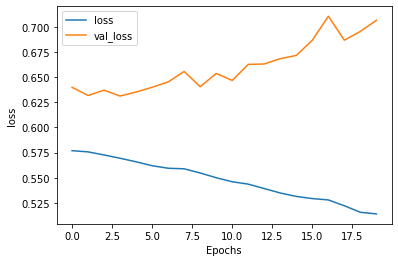

In [27]:

import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'acc')
plot_graphs(history, 'loss')

In [21]:
model.save("rumor_detection_word_embeddin_20iterations.h5")

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())